# Problem Statement
Based on the given features and the causualities of part of the passanger on Titanic, predict whether some other passanger has survied the sinking of Titanic given some of the features.

# Group Members and Contributions 

Zhang Zeyu (1620474K): part of feature encoding, PCA, machine learning model selection, model evaluation and parameter tuning, prediction results analysis 

Lim Chiun Hao (U1821328D): data exploration, data visualisation and familiarisation

Gabriel Hsu (U1840197K): data pre-processing, machine learning techniques

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from collections import Counter
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import Data

In [3]:
#import io
#import requests
url = 'https://raw.githubusercontent.com/zyzhang1130/CE9010/master/Titanic/train.csv'
df = pd.read_csv(url)
#s=requests.get(url).content
#df=pd.read_csv(io.StringIO(s.decode('utf-8')))
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data Exploration

In [4]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Observation:

1. All features, except "Age", have 891 training data.
2. "Age" consists of a few missing data.
3. Mean for "Survived" is less than 0.5, indicating most passengers/crews on board did not survive.

## Visualise "Survived"

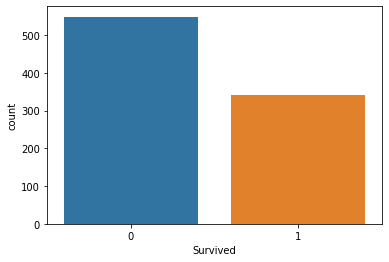

In [34]:
sb.countplot(df["Survived"])

In [35]:
print("Number of Survived=0 and Survived=1") 
print(df["Survived"].value_counts())

Number of Survived=0 and Survived=1
0    549
1    342
Name: Survived, dtype: int64


Observations:
1. Most of the passengers/crews on board did not survive.
2. 549 passengers/crews out of 891 died.

## Visualise "Sex"

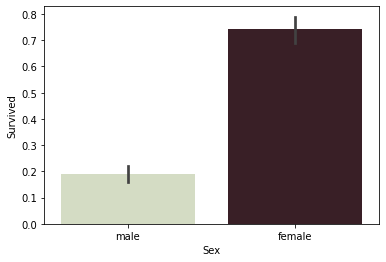

In [36]:
sb.barplot(x="Sex", y="Survived", data=df, palette="ch:0.6")

In [37]:
print("Survival rate:")
print("Female: ", df['Survived'][df['Sex'] == "female"].value_counts(normalize=True)[1])
print("Male: ", df['Survived'][df['Sex'] == "male"].value_counts(normalize=True)[1])

Survival rate:
Female:  0.7420382165605095
Male:  0.18890814558058924


Observations:
1. The survival rate for females is much higher than that for males.
2. Less than 20% of males survived but more than 70% of females survived.

## Visualise "Age"

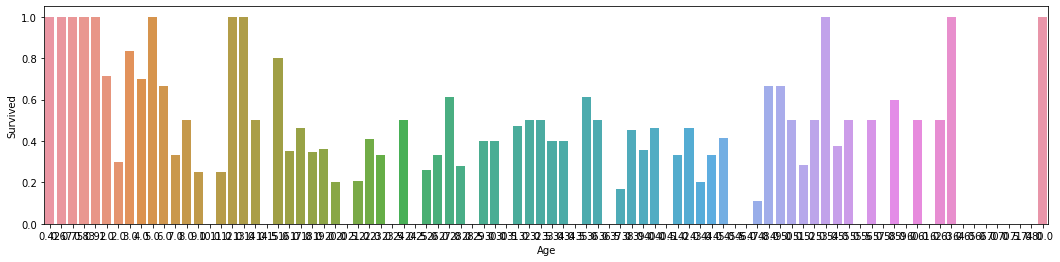

In [38]:
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
sb.barplot(x='Age', y='Survived', data=df[["Age", "Survived"]].groupby(['Age'],as_index=False).mean())

Observation:
1. The age distribution can be divided into 4 groups with a general decreasing trend in the survival rate.
2. First group (Age 0 to 2) has a very high survival rate.
3. Second group (Age 2 to 15) has a lower survival rate than the first group.
4. Third group (Age 15 to 50) has an even lower survival rate.
5. The last group (Age 50 to 80) has an increase in survival rate. This could be due to a smaller number of data in this age range which caused some anomaly.

In [39]:
import plotly.express as px

fig = px.density_heatmap(df, x="Age", y="Survived", marginal_x="histogram", marginal_y="histogram")
fig.show()

![alt text](https://raw.githubusercontent.com/zyzhang1130/CE9010/master/Titanic/heatmap.PNG)

Observations:
1. Most of the passengers/crews who survived are within the age range of 20-30.
2. Most of the passengers/crews who did not survive are also within the age range of 20-30.
3. This is consistent with the fact that the population with age 20-30 is the highest.

## Visualise "Pclass"

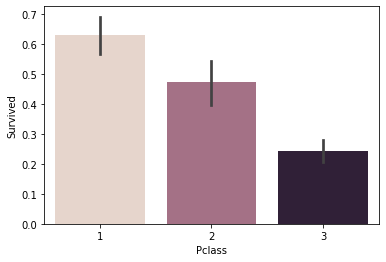

In [40]:
sb.barplot(x="Pclass", y="Survived", data=df, palette="ch:0.1")

In [41]:
print("Survival rate:")
print("Pclass=1: ", df['Survived'][df['Pclass'] == 1].value_counts(normalize=True)[1])
print("Pclass=2: ", df['Survived'][df['Pclass'] == 2].value_counts(normalize=True)[1])
print("Pclass=3: ", df['Survived'][df['Pclass'] == 3].value_counts(normalize=True)[1])

Survival rate:
Pclass=1:  0.6296296296296297
Pclass=2:  0.47282608695652173
Pclass=3:  0.24236252545824846


Observation:
1. Class 1 passengers have the highest survival rate.
2. Class 3 passengers have the lowest survival rate.


# Data Pre-processing



The data provided contained a mix of numerical, nominal, ordinal and binary data. We used different encoding methods for the data which will be examined below.


## Feature Encoding


'PassengerId' is the same as index therefore it is not needed in as a feature:

In [0]:
df = df.drop(columns="PassengerId")

### Binary Features

Amongst all the fearues given, only 'Sex' is binary. We now use dictionary to map its value 'male' and 'female' to binary value '0' and '1':

In [0]:
sex_map = {'male': 1, 'female': 0}
df['Sex'] = df['Sex'].map(sex_map)

### Ordinal Features

'Ticket class' is the only nominal feature given. Since it value is already '1', '2' and '3', no encoding is needed.

### Nominal Features

'Name', 'Ticket', 'Cabin' and 'Embarked' are nominal features. We think 'Name' has little to do with the survial of the passangers and it is unique for each passanger, therefore it is not a relevant feature. To double check that it is true, we count the number of times every name appeared in the training dataset:

In [7]:
from collections import Counter
count_no=[]
count = Counter(df['Name'])
for i in count:
    count_no.append(count[i])
#print(count)
print('number of the instances:',len(df['Name']))
print('number of unique names:',len(count))
print('most frequently appeared name:',max(count))
print('maximum number of appearance:',max(count_no))

number of the instances: 891
number of unique names: 891
most frequently appeared name: van Melkebeke, Mr. Philemon
maximum number of appearance: 1


Which is what we expected. We drop 'Name':

In [0]:
df = df.drop(columns="Name")

We check the feature 'Ticket' which is supposed to be similar to 'Name':

In [9]:
count_no=[]
count = Counter(df['Ticket'])
for i in count:
    count_no.append(count[i])
#print(count)
print('number of the instances:',len(df['Ticket']))
print('number of unique tickets:',len(count))
print('most frequently appeared ticket:',max(count))
print('maximum number of apperance:',max(count_no))

number of the instances: 891
number of unique tickets: 681
most frequently appeared ticket: WE/P 5735
maximum number of apperance: 7


So 'Ticket' is a sparse feature rather than unique for every instance. But since it is difficult to generalize (understand the similarities betweeen instances), we drop it for now:

In [0]:
df = df.drop(columns="Ticket")

We treat 'Cabin' as a nominal feature for now and investigate it:

In [11]:
count_no=[]
count = Counter(df['Cabin'])
for i in count:
    count_no.append(count[i])
#print(count)
print('number of the instances:',len(df['Cabin']))
print('number of unique cabins:',len(count))
print('maximum number of apperance:',max(count_no))


number of the instances: 891
number of unique cabins: 148
maximum number of apperance: 687


We can see that this feature is also quite sqarse and there are a lot of missing values for many instances.
Therefore, we use the first alphabet appeared as the value of the feature and label the missing value with a different string. After that, we use one-hot encoding to encode this featrue.

In [0]:
df['Cabin'] = df['Cabin'].replace(np.nan, 'U', regex=True)
for i in range(df.shape[0]):
    df.loc[i,'Cabin'] = df.loc[i,'Cabin'][0]
df = pd.concat([df,pd.get_dummies(df['Cabin'], prefix='Cabin')],axis=1)
df = df.drop(columns="Cabin")

It is worth noting that, after checking the test data, there is no value 'T' ('Cabin' started with alphabet 'T'). Therefore, we drop the 'T' column:

In [0]:
df = df.drop(columns="Cabin_T")

### Numerical Feature

'Age', 'SibSp'(no. of siblings / spouses aboard the Titanic), 'Parch'(no. of parents / children aboard the Titanic) and 'Fare'(Passenger fare) have numerical values, some are integers while others are can be non-integers. They can be directly used as labels but there are again missing values. After trial and error, we cound that it is most effective by filling those missing values with the median of all values in that that particalr feature:

In [0]:
from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
df[['Age']] = imputer.fit_transform(df[['Age']])

### Exception

'Embarked' fearture is supposed to be a nominal featrue; however, we discovered that it will give a higher accuracy if it is encoded as a ordinal feature (is misisng values under 'embarked' is encoded as another integer as well): 

In [0]:
Embarked_map = {'S':0, 'C': 1, 'Q': 2}
df['Embarked'] = df['Embarked'].map(Embarked_map)
df['Embarked'] = df['Embarked'].replace(np.nan, 3, regex=True)

move the label to the last column

In [0]:
Survived = df["Survived"]
df = df.drop(columns="Survived")
df = pd.concat([df,Survived],axis=1)

In [17]:
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_U,Survived
0,3,1,22.0,1,0,7.2500,0.0,0,0,0,0,0,0,0,1,0
1,1,0,38.0,1,0,71.2833,1.0,0,0,1,0,0,0,0,0,1
2,3,0,26.0,0,0,7.9250,0.0,0,0,0,0,0,0,0,1,1
3,1,0,35.0,1,0,53.1000,0.0,0,0,1,0,0,0,0,0,1
4,3,1,35.0,0,0,8.0500,0.0,0,0,0,0,0,0,0,1,0


## Feature scaling

We tried different order. Applyinh z-scoring first then max normalization gives better prediction accuracy for this dataset.

### z-scoring

We considered the possibility of only doing z-scoreing for numerical freatures while leaving categorical features unchanged. However, z-scoring all features gives a better accuracy for this dataset.

In [0]:
data=df.to_numpy()
n1 = data.shape[0]
n2 = data.shape[1]
m=int(0.8*n1)
for i in range(n2-1):
    data[:,i] = (data[:,i] - data[:,i].mean())/data[:,i].std()  

### Max normalization


We considered the possibility of doing max normalization for all freaturesd. However, only applying max normalization for numerical freatures while leaving categorical features unchanged gives a better accuracy for this dataset.

In [0]:
for i in range(n1):
        data[i,2]=data[i,2]/abs(max(data[:,2]))
        data[i,5]=data[i,5]/abs(max(data[:,5]))

To double check if there are still NaN enties in that dataset

In [20]:
np.isnan(data).any()

False

To check which entries is/are NaN if there is any:

In [21]:
nan=[]
for i in range(n1):
    for j in range(n2):
        if np.isnan(data[i,j]):
            nan.append([i,j])
print(nan)

[]


# Split into training set and testing set

In [0]:
train=data[:m,:]
test=data[m:-1,:]
X = data[:,0:(n2-1)]
y = data[:,(n2-1)]
X_train = train[:,0:(n2-1)]
y_train = train[:,(n2-1)]
X_test = test[:,0:(n2-1)]
y_test = test[:,(n2-1)]

# Machine Learning Model Selection

We tried a variety of machine learning (ML) models to see which one suits our task the most. 
This models include:
K nearest neighbors classifier,
Support vector machine,
Gaussian process classifier,
Decision tree classifier,
Random forest classifier,
Multilayer perceptron classifier,
Artificial neural network classifier,
Logistic regression classifier,
AdaBoost classifier,
Naive Bayes classifier,
Quadratic discriminant analysis classifier,
XGBoost classifier,
Gradient boost classifier,
Ensemble learning classifier (by voting)
Ensemble learning classifier (by stacking)


The available data are splitted into ‘training data’ and ‘test data’ first with 8:2 ratio after encoding phase. Then all models are given the identical encoded training data and certain metric to compare which one is better at the given task after being optimized.


In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier


names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
          "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
          "Naive Bayes", "QDA","GradientBoosting","LogisticRegression"]



classifiers = [
    KNeighborsClassifier(n_neighbors=7,weights='distance'),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0),
    LogisticRegression(C=0.123456789, solver="lbfgs", max_iter=5000)]

# Parameter Tuning

The optimization is done by tuning the hyperparameters of the given ML model. The selection of the optimal set of hyperparameters is done through grid search. 

Grid search is a brute force method to find the optimal set of hyper parameters. Basically, for a given ML model, assume it has n number of adjustable hyperparameters, then we have a search space of n dimensions, in which any point corresponds to a specific set of hyperparameters. The hyperparameters can be either continuous or discrete. For example, for support vector machine (SVM), we can choose its kernel type and the strength of the regularization as dimension x and y, where x is discrete with values ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or ‘callable’ and y a positive real number. If we discretize y then the search space is the 2-dimensional grid formed by all possible combinations of x and y. The idea of grid search is to execute all possible instances in the grids and to select the best set of hyperparameters. Just like the strength of the regularization for SVM, many hyperparameters are continuous and the interval is infinitely large, therefore practically there is no way to exhaust all possible combinations. A trick is used here to make such a formidable task possible. For continuous parameters, we try to find  the optimal order of magnitude first. Still use SVM as an example, we can try all the combination of all values of x with y set to 10^-3,10^-2,10^-1,10^0,10^1,10^2,10^3, when the best set amongst the combinations of these values are selected, say 101, then set y to from 1 to 100 and choose the best y. This approach can drastically reduce the amount of computations needed to be done without missing the optimal solution, assuming the performance of the ML model does not change abruptly with respect to the values of its hyperparameters within the same order of magnitude.


In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [10, 1, 1e-1,1e-2, 1e-3],
                     'C': [1, 10, 100, 1000, 10000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000, 10000]}]


print()

clf = GridSearchCV(
    SVC(), tuned_parameters, scoring='accuracy',cv=10
)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()


Based on the best parameters, we shorten the range:

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.001,0.002,0.003,0.004],
                     'C': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],'probability':[True,False]}]


print()

clf = GridSearchCV(
    SVC(), tuned_parameters, scoring='accuracy',cv=10
)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()



Best parameters set found on development set:

{'C': 0.5, 'gamma': 0.004, 'kernel': 'rbf', 'probability': True}

Grid scores on development set:

0.615 (+/-0.034) for {'C': 0.4, 'gamma': 0.001, 'kernel': 'rbf', 'probability': True}
0.615 (+/-0.034) for {'C': 0.4, 'gamma': 0.001, 'kernel': 'rbf', 'probability': False}
0.701 (+/-0.071) for {'C': 0.4, 'gamma': 0.002, 'kernel': 'rbf', 'probability': True}
0.701 (+/-0.071) for {'C': 0.4, 'gamma': 0.002, 'kernel': 'rbf', 'probability': False}
0.768 (+/-0.098) for {'C': 0.4, 'gamma': 0.003, 'kernel': 'rbf', 'probability': True}
0.768 (+/-0.098) for {'C': 0.4, 'gamma': 0.003, 'kernel': 'rbf', 'probability': False}
0.775 (+/-0.090) for {'C': 0.4, 'gamma': 0.004, 'kernel': 'rbf', 'probability': True}
0.775 (+/-0.090) for {'C': 0.4, 'gamma': 0.004, 'kernel': 'rbf', 'probability': False}
0.674 (+/-0.032) for {'C': 0.5, 'gamma': 0.001, 'kernel': 'rbf', 'probability': True}
0.674 (+/-0.032) for {'C': 0.5, 'gamma': 0.001, 'kernel': 'rbf', 'probabili

F1-score, which is a combined metric of both precision and recall, is also included. Since the Titanic dataset is unbalanced in terms of the survival rate, it is good to use f1-score as a measure to determine the reliability of the accuracy for this binary classification problem.

# Model Evaluation

In the grid search phase, the optimal set of hyperparameters are selected based on the accuracy on the pre-split test data result. The models are trained using the splited traning set earlier. Afterwards, the model with selected hyperparameters are evaluated with 10-fold cross-validation to provide a benchmark to compare to the real submission scores. For the sake of practicality and the interest of time limit, the grid search is not done exhuastively with respect to all adjustable hyperparameters the some of  the ranges for numerical values are more based on educated guess and intuition.

## Import Test Dataset

In [0]:
url2 = 'https://raw.githubusercontent.com/zyzhang1130/CE9010/master/Titanic/test.csv'
df2 = pd.read_csv(url2)

In [0]:
df2.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Test Set Pre-processing

we preprocess the testset in exactally the same manner as training set: 

In [0]:
Embarked_map = {'S':0, 'C': 1, 'Q': 2}
sex_map = {'male': 1, 'female': 0}


df2['Embarked'] = df2['Embarked'].map(Embarked_map)
df2['Sex'] = df2['Sex'].map(sex_map)


df2 = df2.drop(columns="PassengerId")
df2 = df2.drop(columns="Name")
df2 = df2.drop(columns="Ticket")

#data cleaning (replace this missing numerical feature entries with the median of that entry. Can try other methods)
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
df2[['Age']] = imputer.fit_transform(df2[['Age']])
df2[['Fare']] = imputer.fit_transform(df2[['Fare']])


#data cleaning (replace NaN in categorical features with the same string can try other methods)
df2['Embarked'] = df2['Embarked'].replace(np.nan, 3, regex=True)
df2['Cabin'] = df2['Cabin'].replace(np.nan, 'U', regex=True)
for i in range(df2.shape[0]):
    df2.loc[i,'Cabin'] = df2.loc[i,'Cabin'][0]
df2 = pd.concat([df2,pd.get_dummies(df2['Cabin'], prefix='Cabin')],axis=1)
df2 = df2.drop(columns="Cabin")

df2.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_U
0,3,1,34.5,0,0,7.8292,2,0,0,0,0,0,0,0,1
1,3,0,47.0,1,0,7.0000,0,0,0,0,0,0,0,0,1
2,2,1,62.0,0,0,9.6875,2,0,0,0,0,0,0,0,1
3,3,1,27.0,0,0,8.6625,0,0,0,0,0,0,0,0,1
4,3,0,22.0,1,1,12.2875,0,0,0,0,0,0,0,0,1


In [0]:

data2=df2.to_numpy()
n1 = data2.shape[0]
n2 = data2.shape[1]
print(np.isnan(data2).any())
nan=[]
for i in range(n1):
    for j in range(n2):
        if np.isnan(data2[i,j]):
            nan.append([i,j])
print(nan)

for i in range(n2-1):
    data2[:,i] = (data2[:,i] - data2[:,i].mean())/data2[:,i].std()  
for i in range(n1):
        data2[i,2]=data2[i,2]/abs(max(data2[:,2]))
        data2[i,5]=data2[i,5]/abs(max(data2[:,5]))
X_test2=data2

False
[]


## Support Vector Machine

Support vector machine is already tuned as an example in the previous section

### Cross-validation

In [0]:
clf = SVC(C= 0.5, gamma= 0.004, kernel= 'rbf', probability= True)
score=cross_validate(clf, X, y, cv=10, scoring="accuracy")["test_score"].mean()
print(f"{score:.6f}")

0.784494


### Generating Predicion Result for submission in .csv format

In [0]:
df2 = pd.read_csv(url2)
clf = SVC(C= 0.5, gamma= 0.004, kernel= 'rbf', probability= True)
clf.fit(X, y)
pred=clf.predict(X_test2)
pd.DataFrame({"PassengerId": df2["PassengerId"], "Survived": pred}).to_csv("svm_submission.csv", index=False)

![alt text](https://raw.githubusercontent.com/zyzhang1130/CE9010/master/Titanic/svm.PNG)

## Logistic Regression


In [0]:

from sklearn.metrics import accuracy_score
tuned_parameters = [
                    {'penalty': ['l2'],
                     'C': [0.01,0.1,1.0,10], 'fit_intercept':[True,False], 'solver':['liblinear','newton-cg', 'lbfgs', 'sag', 'saga'],
                     'max_iter':[100,500,1000,1500,2000],'warm_start':[True, False],'fit_intercept':[True, False],
                     'tol':[0.00001,0.0001,0.001,0.01,0.1]},
                    {'penalty': ['l1', 'elasticnet', 'none'],
                     'C': [0.01,0.1,1.0,10], 'fit_intercept':[True,False], 'solver':[ 'liblinear', 'saga'],
                     'max_iter':[100,500,1000,1500,2000],'warm_start':[True, False],'fit_intercept':[True, False],
                     'tol':[0.00001,0.0001,0.001,0.01,0.1]}
                    ]


print()

clf = GridSearchCV(
    LogisticRegression(), tuned_parameters, scoring='accuracy',cv=10
)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()


Streaming output truncated to the last 5000 lines.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not conv

Best parameters set found on development set:

{'C': 10, 'fit_intercept': True, 'max_iter': 1500, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.1, 'warm_start': False}

Grid scores on development set:

0.773 (+/-0.074) for {'C': 0.01, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 1e-05, 'warm_start': True}
0.773 (+/-0.074) for {'C': 0.01, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 1e-05, 'warm_start': False}
0.773 (+/-0.074) for {'C': 0.01, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001, 'warm_start': True}
0.773 (+/-0.074) for {'C': 0.01, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001, 'warm_start': False}
0.773 (+/-0.074) for {'C': 0.01, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.001, 'warm_start': True}
0.773 (+/-0.074) for {'C': 0.01, 'fit_intercept': True, 

### Cross-validation

In [0]:
clf = LogisticRegression(C= 10, fit_intercept= True, max_iter= 1500, penalty= 'l1', solver= 'liblinear', tol= 0.1, warm_start= False)
score=cross_validate(clf, X, y, cv=10, scoring="accuracy")["test_score"].mean()
print(f"{score:.6f}")

0.796879


### Generating Predicion Result for submission in .csv format

In [0]:
df2 = pd.read_csv(url2)
clf = LogisticRegression(C= 10, fit_intercept= True, max_iter= 1500, penalty= 'l1', solver= 'liblinear', tol= 0.1, warm_start= False)
clf.fit(X, y)
pred=clf.predict(X_test2)
pd.DataFrame({"PassengerId": df2["PassengerId"], "Survived": pred}).to_csv("log_reg_submission.csv", index=False)

The generated results csv file need to be copied and pasted to another csv file in order to make a successful submisison due to an unknown formatting issue.

### Kaggle Submisison Score

![alt text](https://raw.githubusercontent.com/zyzhang1130/CE9010/master/Titanic/logistic_regression.png)

## K-nearest Neighbors Classifier

In [0]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
tuned_parameters = [{'n_neighbors': [1, 10, 20, 30],
                     'weights': ['uniform', 'distance']}
                    ]


print()

clf = GridSearchCV(
    KNeighborsClassifier(), tuned_parameters, scoring='accuracy',cv=10
)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()



Best parameters set found on development set:

{'n_neighbors': 20, 'weights': 'uniform'}

Grid scores on development set:

0.709 (+/-0.149) for {'n_neighbors': 1, 'weights': 'uniform'}
0.709 (+/-0.149) for {'n_neighbors': 1, 'weights': 'distance'}
0.791 (+/-0.080) for {'n_neighbors': 10, 'weights': 'uniform'}
0.758 (+/-0.098) for {'n_neighbors': 10, 'weights': 'distance'}
0.799 (+/-0.106) for {'n_neighbors': 20, 'weights': 'uniform'}
0.765 (+/-0.094) for {'n_neighbors': 20, 'weights': 'distance'}
0.785 (+/-0.108) for {'n_neighbors': 30, 'weights': 'uniform'}
0.767 (+/-0.100) for {'n_neighbors': 30, 'weights': 'distance'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86       114
         1.0       0.77      0.72      0.74        64

    accuracy                           0.82       178
   macro avg   

In [0]:


tuned_parameters = [{'n_neighbors': [15,16,17,18,19,20,21,22,23,24,25],
                     'weights': [ 'distance']}
                    ]


print()

clf = GridSearchCV(
    KNeighborsClassifier(), tuned_parameters, scoring='accuracy', cv=10
)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()



Best parameters set found on development set:

{'n_neighbors': 24, 'weights': 'distance'}

Grid scores on development set:

0.764 (+/-0.097) for {'n_neighbors': 15, 'weights': 'distance'}
0.764 (+/-0.093) for {'n_neighbors': 16, 'weights': 'distance'}
0.764 (+/-0.093) for {'n_neighbors': 17, 'weights': 'distance'}
0.765 (+/-0.094) for {'n_neighbors': 18, 'weights': 'distance'}
0.764 (+/-0.090) for {'n_neighbors': 19, 'weights': 'distance'}
0.765 (+/-0.094) for {'n_neighbors': 20, 'weights': 'distance'}
0.765 (+/-0.095) for {'n_neighbors': 21, 'weights': 'distance'}
0.765 (+/-0.094) for {'n_neighbors': 22, 'weights': 'distance'}
0.768 (+/-0.088) for {'n_neighbors': 23, 'weights': 'distance'}
0.770 (+/-0.090) for {'n_neighbors': 24, 'weights': 'distance'}
0.770 (+/-0.094) for {'n_neighbors': 25, 'weights': 'distance'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall 

However, when we use this selected parameters, it did not produce a better result than when 'n_neighbors'=7. This is likely due to the fact that the training dataset size is rather limited and hence even cross-validation was applied, overfitting still occurred.

### Cross-validation

In [0]:
clf = KNeighborsClassifier(n_neighbors=7,weights='distance')
score=cross_validate(clf, X, y, cv=10, scoring="accuracy")["test_score"].mean()
print(f"{score:.6f}")

0.774407


### Generating Predicion Result for submission in .csv format

In [0]:
df2 = pd.read_csv(url2)
clf = KNeighborsClassifier(n_neighbors=7,weights='distance')
clf.fit(X, y)
pred=clf.predict(X_test2)
pd.DataFrame({"PassengerId": df2["PassengerId"], "Survived": pred}).to_csv("knn_submission.csv", index=False)

![alt text](https://raw.githubusercontent.com/zyzhang1130/CE9010/master/Titanic/knn.PNG)

## DecisionTreeClassifier

In [0]:


tuned_parameters = [{'max_depth': [4,5,6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]}
                    ]


print()

clf = GridSearchCV(
    DecisionTreeClassifier(), tuned_parameters, scoring='accuracy', cv=10
)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()



Best parameters set found on development set:

{'max_depth': 7}

Grid scores on development set:

0.774 (+/-0.061) for {'max_depth': 4}
0.803 (+/-0.087) for {'max_depth': 5}
0.791 (+/-0.130) for {'max_depth': 6}
0.805 (+/-0.114) for {'max_depth': 7}
0.788 (+/-0.127) for {'max_depth': 8}
0.791 (+/-0.111) for {'max_depth': 9}
0.784 (+/-0.085) for {'max_depth': 10}
0.795 (+/-0.103) for {'max_depth': 11}
0.780 (+/-0.131) for {'max_depth': 12}
0.782 (+/-0.121) for {'max_depth': 13}
0.777 (+/-0.139) for {'max_depth': 14}
0.773 (+/-0.112) for {'max_depth': 15}
0.773 (+/-0.122) for {'max_depth': 16}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.82      0.93      0.87       114
         1.0       0.83      0.62      0.71        64

    accuracy                           0.82       178
   macro avg       0.82      0.78      0.79  

### Cross-validation

In [0]:
clf = DecisionTreeClassifier(max_depth=7)
score=cross_validate(clf, X, y, cv=10, scoring="accuracy")["test_score"].mean()
print(f"{score:.6f}")

0.794657


### Generating Predicion Result for submission in .csv format

In [0]:
df2 = pd.read_csv(url2)
clf = DecisionTreeClassifier(max_depth=7)
clf.fit(X, y)
pred=clf.predict(X_test2)
pd.DataFrame({"PassengerId": df2["PassengerId"], "Survived": pred}).to_csv("DecisionTree_submission.csv", index=False)

![alt text](https://raw.githubusercontent.com/zyzhang1130/CE9010/master/Titanic/DecisionTree.PNG)

## GaussianProcessClassifier

In [0]:


tuned_parameters = [{'kernel':[1.0 * RBF(0.8),1.0 * RBF(0.9),1.0 * RBF(1.0),1.0 * RBF(1.1),1.0 * RBF(1.2),1.0 * RBF(1.3)]}
                    ]


print()

clf = GridSearchCV(
    GaussianProcessClassifier(), tuned_parameters, scoring='accuracy', cv=10
)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()



Best parameters set found on development set:

{'kernel': 1**2 * RBF(length_scale=0.8)}

Grid scores on development set:

0.794 (+/-0.078) for {'kernel': 1**2 * RBF(length_scale=0.8)}
0.794 (+/-0.078) for {'kernel': 1**2 * RBF(length_scale=0.9)}
0.794 (+/-0.078) for {'kernel': 1**2 * RBF(length_scale=1)}
0.794 (+/-0.078) for {'kernel': 1**2 * RBF(length_scale=1.1)}
0.794 (+/-0.078) for {'kernel': 1**2 * RBF(length_scale=1.2)}
0.794 (+/-0.078) for {'kernel': 1**2 * RBF(length_scale=1.3)}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.86      0.89      0.88       114
         1.0       0.80      0.73      0.76        64

    accuracy                           0.84       178
   macro avg       0.83      0.81      0.82       178
weighted avg       0.84      0.84      0.84       178




### Cross-validation

In [0]:
clf = GaussianProcessClassifier(1**2 * RBF(length_scale=0.8))
score=cross_validate(clf, X, y, cv=10, scoring="accuracy")["test_score"].mean()
print(f"{score:.6f}")

0.815943


### Generating Predicion Result for submission in .csv format

In [0]:
df2 = pd.read_csv(url2)
clf = GaussianProcessClassifier(1**2 * RBF(length_scale=0.8))
clf.fit(X, y)
pred=clf.predict(X_test2)
pd.DataFrame({"PassengerId": df2["PassengerId"], "Survived": pred}).to_csv("GaussianProcess_submission.csv", index=False)

![alt text](https://raw.githubusercontent.com/zyzhang1130/CE9010/master/Titanic/GaussianProcess.PNG)

## BaggingClassifier

In [0]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
tuned_parameters = [{ 'n_estimators':[8,9,10,11,12,13,14,15],'warm_start':[ False],'bootstrap':[True, False],'bootstrap_features':[True, False]}
                    ]


print()

clf = GridSearchCV(
    BaggingClassifier(), tuned_parameters, scoring='accuracy', cv=10
)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()



Best parameters set found on development set:

{'bootstrap': True, 'bootstrap_features': True, 'n_estimators': 10, 'warm_start': False}

Grid scores on development set:

0.787 (+/-0.098) for {'bootstrap': True, 'bootstrap_features': True, 'n_estimators': 8, 'warm_start': False}
0.778 (+/-0.114) for {'bootstrap': True, 'bootstrap_features': True, 'n_estimators': 9, 'warm_start': False}
0.808 (+/-0.097) for {'bootstrap': True, 'bootstrap_features': True, 'n_estimators': 10, 'warm_start': False}
0.788 (+/-0.130) for {'bootstrap': True, 'bootstrap_features': True, 'n_estimators': 11, 'warm_start': False}
0.785 (+/-0.105) for {'bootstrap': True, 'bootstrap_features': True, 'n_estimators': 12, 'warm_start': False}
0.785 (+/-0.101) for {'bootstrap': True, 'bootstrap_features': True, 'n_estimators': 13, 'warm_start': False}
0.792 (+/-0.084) for {'bootstrap': True, 'bootstrap_features': True, 'n_estimators': 14, 'warm_start': False}
0.795 (+/-0.119) for {'bootstrap': True, 'bootstrap_features'

### Cross-validation

In [0]:
clf = BaggingClassifier(bootstrap= True, bootstrap_features= True, n_estimators= 10, warm_start= False)
score=cross_validate(clf, X, y, cv=10, scoring="accuracy")["test_score"].mean()
print(f"{score:.6f}")

0.792409


### Generating Predicion Result for submission in .csv format

In [0]:
df2 = pd.read_csv(url2)
clf = BaggingClassifier(bootstrap= True, bootstrap_features= True, n_estimators= 10, warm_start= False)
clf.fit(X, y)
pred=clf.predict(X_test2)
pd.DataFrame({"PassengerId": df2["PassengerId"], "Survived": pred}).to_csv("Bagging_submission.csv", index=False)

![alt text](https://raw.githubusercontent.com/zyzhang1130/CE9010/master/Titanic/bagging.PNG)

## MLPClassifier

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
tuned_parameters = [{ 'alpha':[0.0001,0.001,0.01,0.1,1], 'max_iter':[1000,1500,2000],
      'solver':['adam'], 'early_stopping':[True, False]},
                    { 'alpha':[0.0001,0.001,0.01,0.1,1],
'max_iter':[1000,1500,2000],'momentum':[0.1,0.3,0.5,0.7,0.9],
                     'solver':['sgd'], 'early_stopping':[True, False],'learning_rate':['constant','invscaling','adaptive']},
                    ]


print()

clf = GridSearchCV(
    MLPClassifier(), tuned_parameters, scoring='accuracy', cv=10
)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()



Best parameters set found on development set:

{'alpha': 0.01, 'early_stopping': False, 'max_iter': 2000, 'solver': 'adam'}

Grid scores on development set:

0.791 (+/-0.091) for {'alpha': 0.0001, 'early_stopping': True, 'max_iter': 1000, 'solver': 'adam'}
0.777 (+/-0.090) for {'alpha': 0.0001, 'early_stopping': True, 'max_iter': 1500, 'solver': 'adam'}
0.767 (+/-0.089) for {'alpha': 0.0001, 'early_stopping': True, 'max_iter': 2000, 'solver': 'adam'}
0.805 (+/-0.080) for {'alpha': 0.0001, 'early_stopping': False, 'max_iter': 1000, 'solver': 'adam'}
0.796 (+/-0.090) for {'alpha': 0.0001, 'early_stopping': False, 'max_iter': 1500, 'solver': 'adam'}
0.798 (+/-0.095) for {'alpha': 0.0001, 'early_stopping': False, 'max_iter': 2000, 'solver': 'adam'}
0.774 (+/-0.089) for {'alpha': 0.001, 'early_stopping': True, 'max_iter': 1000, 'solver': 'adam'}
0.770 (+/-0.087) for {'alpha': 0.001, 'early_stopping': True, 'max_iter': 1500, 'solver': 'adam'}
0.787 (+/-0.115) for {'alpha': 0.001, 'early_sto

### Cross-validation

In [0]:
clf = MLPClassifier(alpha= 0.01, early_stopping= False, max_iter= 2000, solver='adam')
score=cross_validate(clf, X, y, cv=10, scoring="accuracy")["test_score"].mean()
print(f"{score:.6f}")

0.801348


### Generating Predicion Result for submission in .csv format

In [0]:
df2 = pd.read_csv(url2)
clf = MLPClassifier(alpha= 0.01, early_stopping= False, max_iter= 2000, solver='adam')
clf.fit(X, y)
pred=clf.predict(X_test2)
pd.DataFrame({"PassengerId": df2["PassengerId"], "Survived": pred}).to_csv("MLP_submission.csv", index=False)

![alt text](https://raw.githubusercontent.com/zyzhang1130/CE9010/master/Titanic/mlp.PNG)

## Gradient Boosting Classifier

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
tuned_parameters = [{ 'loss':['deviance', 'exponential'], 'learning_rate':[0.001,0.01,0.1,1],
      'warm_start':[True, False], 'max_depth':[1,2,3,4,5,6,7,8,9]}
                    ]


print()

clf = GridSearchCV(
    GradientBoostingClassifier(), tuned_parameters, scoring='accuracy', cv=10
)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()



Best parameters set found on development set:

{'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 4, 'warm_start': True}

Grid scores on development set:

0.610 (+/-0.011) for {'learning_rate': 0.001, 'loss': 'deviance', 'max_depth': 1, 'warm_start': True}
0.610 (+/-0.011) for {'learning_rate': 0.001, 'loss': 'deviance', 'max_depth': 1, 'warm_start': False}
0.610 (+/-0.011) for {'learning_rate': 0.001, 'loss': 'deviance', 'max_depth': 2, 'warm_start': True}
0.610 (+/-0.011) for {'learning_rate': 0.001, 'loss': 'deviance', 'max_depth': 2, 'warm_start': False}
0.610 (+/-0.011) for {'learning_rate': 0.001, 'loss': 'deviance', 'max_depth': 3, 'warm_start': True}
0.610 (+/-0.011) for {'learning_rate': 0.001, 'loss': 'deviance', 'max_depth': 3, 'warm_start': False}
0.610 (+/-0.011) for {'learning_rate': 0.001, 'loss': 'deviance', 'max_depth': 4, 'warm_start': True}
0.610 (+/-0.011) for {'learning_rate': 0.001, 'loss': 'deviance', 'max_depth': 4, 'warm_start': False}
0.610 (+/-0.011)

### Cross-validation

In [0]:
clf = GradientBoostingClassifier(learning_rate= 0.1, loss= 'exponential', max_depth= 4, warm_start= True)
score=cross_validate(clf, X, y, cv=10, scoring="accuracy")["test_score"].mean()
print(f"{score:.6f}")

0.819363


### Generating Predicion Result for submission in .csv format

In [0]:
df2 = pd.read_csv(url2)
clf = GradientBoostingClassifier(learning_rate= 0.1, loss= 'exponential', max_depth= 4, warm_start= True)
clf.fit(X, y)
pred=clf.predict(X_test2)
pd.DataFrame({"PassengerId": df2["PassengerId"], "Survived": pred}).to_csv("GradientBoosting_submission.csv", index=False)

![alt text](https://raw.githubusercontent.com/zyzhang1130/CE9010/master/Titanic/GradientBoosting.PNG)

## AdaBoost Classifier

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
tuned_parameters = [{'base_estimator':[DecisionTreeClassifier(max_depth=7)], 'n_estimators':[50,60,70,80,90,100,120,140,160,180,200], 'algorithm':['SAMME.R', 'SAMME'],
  'learning_rate':[0.2,0.4,0.6,0.8,1.0,1.2,1.4]}
                    ]


print()

clf = GridSearchCV(
    AdaBoostClassifier(), tuned_parameters, scoring='accuracy', cv=10
)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()



Best parameters set found on development set:

{'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), 'learning_rate': 0.2, 'n_estimators': 200}

Grid scores on development set:

0.778 (+/-0.108) for {'algorithm': 'SAMME.R', 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, pr

### Cross-validation

In [0]:
clf = AdaBoostClassifier(algorithm= 'SAMME', base_estimator= DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), learning_rate= 0.2, n_estimators= 200)
score=cross_validate(clf, X, y, cv=10, scoring="accuracy")["test_score"].mean()
print(f"{score:.6f}")

0.818215


### Generating Predicion Result for submission in .csv format

In [0]:
df2 = pd.read_csv(url2)
clf = AdaBoostClassifier(algorithm= 'SAMME', base_estimator= DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), learning_rate= 0.2, n_estimators= 200)
clf.fit(X, y)
pred=clf.predict(X_test2)
pd.DataFrame({"PassengerId": df2["PassengerId"], "Survived": pred}).to_csv("AdaBoost_submission.csv", index=False)

![alt text](https://raw.githubusercontent.com/zyzhang1130/CE9010/master/Titanic/ada.PNG)

## RandomForest Classifier

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
tuned_parameters = [{ 'n_estimators':[60,70,80,90,100,120,140,160,180,200], 'criterion':['gini','entropy'],
      'warm_start':[True, False], 'bootstrap':[True, False],'min_samples_split':[2,3,4,5,6,7,8,9]}
                    ]


print()

clf = GridSearchCV(
    RandomForestClassifier(), tuned_parameters, scoring='accuracy', cv=10
)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()



Best parameters set found on development set:

{'bootstrap': True, 'criterion': 'gini', 'min_samples_split': 8, 'n_estimators': 180, 'warm_start': False}

Grid scores on development set:

0.796 (+/-0.124) for {'bootstrap': True, 'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 60, 'warm_start': True}
0.787 (+/-0.104) for {'bootstrap': True, 'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 60, 'warm_start': False}
0.796 (+/-0.124) for {'bootstrap': True, 'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 70, 'warm_start': True}
0.799 (+/-0.116) for {'bootstrap': True, 'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 70, 'warm_start': False}
0.799 (+/-0.113) for {'bootstrap': True, 'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 80, 'warm_start': True}
0.789 (+/-0.125) for {'bootstrap': True, 'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 80, 'warm_start': False}
0.787 (+/-0.117) for {'bootstrap': True, 'criterion'

### Cross-validation

In [0]:
clf = RandomForestClassifier(bootstrap= True, criterion= 'gini', min_samples_split= 8, n_estimators= 180, warm_start= False)
score=cross_validate(clf, X, y, cv=10, scoring="accuracy")["test_score"].mean()
print(f"{score:.6f}")

0.835069


### Generating Predicion Result for submission in .csv format

In [0]:
df2 = pd.read_csv(url2)
clf = RandomForestClassifier(bootstrap= True, criterion= 'gini', min_samples_split= 8, n_estimators= 180, warm_start= False)
clf.fit(X, y)
pred=clf.predict(X_test2)
pd.DataFrame({"PassengerId": df2["PassengerId"], "Survived": pred}).to_csv("RandomForestClassifier_submission.csv", index=False)

![alt text](https://raw.githubusercontent.com/zyzhang1130/CE9010/master/Titanic/RandomForest.PNG)

## XGBoost Classifier

In [0]:
from xgboost import XGBClassifier
model = XGBClassifier(learning_rate =0.1,
 n_estimators=1000,
 max_depth=10,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)
print('coss validation results',gsearch1.cv_results_ )
print()
print('best parameters',gsearch1.best_params_)
print()
print('best score',gsearch1.best_score_)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



coss validation results {'mean_fit_time': array([0.41868615, 0.42174573, 0.4636878 , 0.70192904, 0.67201667,
       0.61961665, 0.93390512, 0.80480742, 0.70481453, 1.08129082,
       0.86310353, 0.63918233]), 'std_fit_time': array([0.02233087, 0.01785338, 0.01080505, 0.02454552, 0.02674497,
       0.0341387 , 0.15101574, 0.07040121, 0.15885518, 0.12221958,
       0.05393578, 0.07546581]), 'mean_score_time': array([0.02239423, 0.00688744, 0.00698676, 0.01178517, 0.01662512,
       0.00748129, 0.00846801, 0.00689321, 0.00783014, 0.00812707,
       0.01432238, 0.0042695 ]), 'std_score_time': array([0.0074922 , 0.00096934, 0.00283873, 0.00715047, 0.0030997 ,
       0.00223604, 0.00185373, 0.00198884, 0.00223366, 0.00219941,
       0.00523321, 0.00135888]), 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value='?',
            dtyp

In [0]:
param_test2 = {
 'max_depth':[8,9,10],
 'min_child_weight':[2,3,4]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,y_train)
print('coss validation results',gsearch2.cv_results_ )
print()
print('best parameters',gsearch2.best_params_)
print()
print('best score',gsearch2.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



coss validation results {'mean_fit_time': array([0.92014089, 0.87254848, 0.77533321, 0.97191906, 0.86867752,
       0.76766458, 1.01229377, 0.85765433, 0.64589429]), 'std_fit_time': array([0.04079175, 0.03909655, 0.03449356, 0.0732732 , 0.02433322,
       0.1217465 , 0.04318948, 0.01926955, 0.10747002]), 'mean_score_time': array([0.01254563, 0.01127682, 0.01024442, 0.00755224, 0.01465964,
       0.00669146, 0.00992737, 0.01069221, 0.00542397]), 'std_score_time': array([0.00605097, 0.00665723, 0.00527317, 0.00276047, 0.0068149 ,
       0.00181474, 0.00281513, 0.00507771, 0.00243942]), 'param_max_depth': masked_array(data=[8, 8, 8, 9, 9, 9, 10, 10, 10],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[2, 3, 4, 2, 3, 4, 2, 3, 4],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_v

### Cross-validation

In [0]:
clf = XGBClassifier(learning_rate =0.1,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
score=cross_validate(clf, X, y, cv=10, scoring="accuracy")["test_score"].mean()
print(f"{score:.6f}")

0.804732


### Generating Predicion Result for submission in .csv format

In [0]:
df2 = pd.read_csv(url2)
clf = XGBClassifier(learning_rate =0.1,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
clf.fit(X, y)
pred=clf.predict(X_test2)
pd.DataFrame({"PassengerId": df2["PassengerId"], "Survived": pred}).to_csv("XGBoost_submission.csv", index=False)

![alt text](https://raw.githubusercontent.com/zyzhang1130/CE9010/master/Titanic/XGBoost.PNG)

# Ensembel Learning Classifier

We use selected models with selected parameters to form ensemble classifiers. The ensemble classifiers are cross validated with 10-fold cross validation and with the all the data which have labels. After some trial and errors we realized that the optimal hyperparameters selected from grid search may not correspond to the best submission score. Our guess is that the 'optimal hyper-parameters' could be actually overfitting to the training data. Therefore, there are some changes in the hyper-parameter settings.The result from grid search can be used for reference instead of the absolute standard.

On a side notes, since thr API of AdaBoost classifier and random forest classifier are directly given in the scikit-learn library, despite the fact the technically these two are ensemble learning models as well, we already evaluated them in the previous secion.

## Bagging Classifier

For this bagging classifer we use self-defined base classifier 

In [0]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.ensemble import BaggingClassifier

bclf= BaggingClassifier(LogisticRegression(C=0.123456789, solver="lbfgs", max_iter=5000), random_state=0, warm_start=False,bootstrap=True, bootstrap_features=True, n_estimators= 500)


score=cross_validate(bclf, X, y, cv=10, scoring="accuracy")["test_score"].mean()
print(f"{score:.6f}")

0.797990


### Generating Predicion Result for submission in .csv format

In [0]:
df2 = pd.read_csv(url2)
bclf.fit(X, y)
pred=bclf.predict(X_test2)
pd.DataFrame({"PassengerId": df2["PassengerId"], "Survived": pred}).to_csv("Bagging2_submission.csv", index=False)

![alt text](https://raw.githubusercontent.com/zyzhang1130/CE9010/master/Titanic/bagging2.PNG)

## Stacking Classifier

We use 3-fold cross valisation to evaluate the accuacy of the stacking classifier. 

In [0]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_validate
base_learners  = [('1_1',SVC(gamma=2, C=1,probability=True)),     
                  ('1_2',DecisionTreeClassifier(max_depth=8)),     
                  ('1_3',MLPClassifier(alpha=1, max_iter=1000)),     
                  ('1_4', KNeighborsClassifier(n_neighbors=7,weights='distance')),     
                  ('1_5', BaggingClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=10, random_state=0, warm_start=True)),     
                  ('1_6',GaussianProcessClassifier(0.949**2 * RBF(length_scale=1))),     
                  ('1_7',GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0))]     
stack_clf = StackingClassifier(estimators=base_learners,
                          final_estimator=LogisticRegression(C=0.123456789, solver="lbfgs", max_iter=5000),  
                          cv=10)


score=cross_validate(stack_clf, X, y, cv=10, scoring="accuracy")["test_score"].mean()
print(f"{score:.6f}")

0.819338


### Generating Predicion Result for submission in .csv format

In [0]:
df2 = pd.read_csv(url2)
stack_clf.fit(X, y)
pred=stack_clf.predict(X_test2)
pd.DataFrame({"PassengerId": df2["PassengerId"], "Survived": pred}).to_csv("stacking_submission.csv", index=False)

### Kaggle Submission Score

![alt text](https://raw.githubusercontent.com/zyzhang1130/CE9010/master/Titanic/stacking.PNG)

We observed from trail and error that it is not necessary that the based classifiers that individually perform better will give better score when stacked together. We think of the following possible causes: 
1. Stacking classifier requires the its base classifiers to be at non-correlate as possible. We assume this condition is fulfilled by that fact that these machine learning models are developed based on different mathematical ideals. However, amongst all base classifiers, some classfiers might tend to be more correlated to others. For example, random forest is by its own aready an emsemble classifier which is built from decision trees. Therefore, by definition it cannot be independent from decision trees. In such case, even if both can achieve very good prediction results separetely, if put as base classifiers as the same time this stacking classifier might be outperformed by other choices of base classifiers.
This could happened between other based classifiers as well, but their correlation will be difficult to see.

2. Stacking classifiers also requires each based classifier is better than a random classifier in terms of prediction accuracy. We believe this condition is definitely satisfied as we have already tested the base classifiers individually.

3. It could also be the case that some based classifier, when used together, will cause the stacking classifier to overfit more towards the training data.

## Voting Classifier

We use 3-fold cross valisation to evaluate the accuacy of the stacking classifier. Soft voting scheme (predicts the class label based on the argmax of the sums of the predicted probabilities) is adopted since it gives a better prediction result. 

In [0]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_validate
from sklearn.ensemble import BaggingClassifier
base_learners  = [('1_1',SVC(gamma=2, C=1,probability=True)),
                  ('1_2',DecisionTreeClassifier(max_depth=8)),
                  ('1_3',MLPClassifier(alpha=1, max_iter=1000)),
                  ('1_4', KNeighborsClassifier(n_neighbors=7,weights='distance')),
                  ('1_5', BaggingClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=10, random_state=0, warm_start=True)),
                  ('1_6',GaussianProcessClassifier(0.949**2 * RBF(length_scale=1))),
                  ('1_7',GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)) ]
v_clf = VotingClassifier(estimators=base_learners,voting='soft')

score=cross_validate(v_clf, X, y, cv=10, scoring="accuracy")["test_score"].mean()
print(f"{score:.6f}")

0.821598


### Generating Predicion Result for submission in .csv format

In [0]:
df2 = pd.read_csv(url2)
v_clf.fit(X, y)
pred=v_clf.predict(X_test2)
pd.DataFrame({"PassengerId": df2["PassengerId"], "Survived": pred}).to_csv("voting_submission.csv", index=False)

### Kaggle Submission Score

![alt text](https://raw.githubusercontent.com/zyzhang1130/CE9010/master/Titanic/voting.PNG)

The issue with stacking classidier exists for the voting classidier as well (optimal classifiers may not give optimal result when used together as base classifier). And we reckon the cause could be the same as well. Through multiple testing, we notice that soft voting classifier in general out performs stacking classsifier given the same base classifiers.

# Kaggle Leader Board Ranking

We chose the best classifiers among all the trained ones: voting classifiers. Its score 0.81339 corresponds to 568th-713th positions on the public leaderboard (top 2.96% to top 3.72% on the leaderboard).

# Observations

1. The actual submission score is lower than the cross-validation score for all classifiers. This is expected as overfitting always exists.

2. When tuned carefully and appropriately, ensemble learning methods can outperform individual machine learning models. 

3. According to theory, ensemble methods always outperform the individual classifiers as long as the 2 necessary conditions:

The base classifiers are independent of each other

The base classifiers should do better than a random classifier 

   are satisfied. However, during the trial and error, we noticed that it is actually quite common that the ensemble methods’ performance was lower than that of the best individual classifier used as one of the base classifiers. This sugguests that the based classifiers with lower accuracy comprimosed the best classifier instead of helping to improve the overall accuacy.


# Attempt with Principal Component Analysis

We applied Principal Component Analysis on the preprocessed data in the hope that it could find the most important linear combinations of features:

Text(0.5, 1.0, 'Percentage of data variances captured by all 15 principal directions')

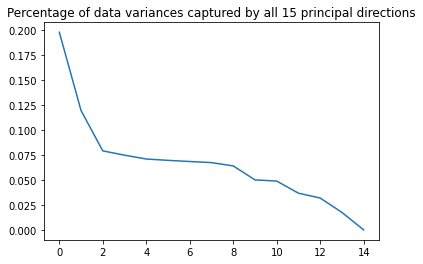

In [23]:
import scipy.linalg as la
from scipy.sparse.linalg import eigsh
import time
from matplotlib import pyplot as plt

def EVD(X):
    s, U = np.linalg.eig(X)
    #s, U = eigsh(X,k=10000)
    idx = s.argsort()[::-1] # decreasing order
    return s[idx], U[:,idx]
  
X -= X.mean(axis=0)
X /= np.std(X,axis=0)
cov = X.T.dot(X) / X.shape[0]
t = time.time()
s, U = EVD(cov)
elapsed = time.time() - t
s, U = np.real(s), np.real(U)

plt.figure()
plt.plot(s[:]/np.sum(s))
plt.title('Percentage of data variances captured by all 15 principal directions')

In [24]:
cov.shape

(15, 15)

## Feature Importance

By observing the eigenvectors with the largest and the second largest variance, we can tell the importance of each original features by comparing the absolute value of it each component. This is because the important new features (top few principal components) are composed by the linear combination of the original features/bases and those original bases with larger magnitude contributed the most of these impact. We focus on those entries with magnitude larger than 0.3.

### First Principal Component

In [25]:
print(U[:,0])

[ 0.50673939  0.14345671 -0.22631347  0.00597827 -0.05491334 -0.38756222
 -0.03493063 -0.11518565 -0.28103787 -0.29322774 -0.18845802 -0.16007677
 -0.03174686 -0.00837895  0.52582331]


In [26]:
sortedarray=np.flip(np.sort(abs(U[:,0])))
print(sortedarray)

[0.52582331 0.50673939 0.38756222 0.29322774 0.28103787 0.22631347
 0.18845802 0.16007677 0.14345671 0.11518565 0.05491334 0.03493063
 0.03174686 0.00837895 0.00597827]


Find the index of the important original features

In [27]:
np.where(np.isclose(abs(U[:,0]), sortedarray[0]) )

(array([14]),)

In [28]:
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_U,Survived
0,3,1,22.0,1,0,7.2500,0.0,0,0,0,0,0,0,0,1,0
1,1,0,38.0,1,0,71.2833,1.0,0,0,1,0,0,0,0,0,1
2,3,0,26.0,0,0,7.9250,0.0,0,0,0,0,0,0,0,1,1
3,1,0,35.0,1,0,53.1000,0.0,0,0,1,0,0,0,0,0,1
4,3,1,35.0,0,0,8.0500,0.0,0,0,0,0,0,0,0,1,0


In [29]:
Cabin_NaN_number=list(df.Cabin_U).count(0)
print(Cabin_NaN_number)

204


Since 0.52582331 corresponds to the NaN one-hot-encoded label for 'Cabin number', and there is a large portion of the passengers (204 out of 891) whose Cabin numbers are missing. It makes sense if we have the following postulate: for the passengers who did not survive, it is much more difficult to determine their Cabin numbers. If that is true, then there would be a lot of passengers whose Cabin number could not be determined, since the majority of them did not survive. This agrees with the fact that there are large amount of NaN in 'Cabin number' features for both training set and test set. Therefore, it is reasoonable that the NaN one-hot-encoded label for 'Cabin number' is strongly correlated to the survival rate, hence the large eigenvalue magnitude.

In [30]:
np.where(np.isclose(abs(U[:,0]), sortedarray[2]) )

(array([5]),)

The second largest value 0.50673939 corresponds to the feature 'Ticket class'. It does make sense as the higher class passenger is likely to get to access of evacuation facilities with relative ease. 

In [31]:
np.where(np.isclose(abs(U[:,0]), sortedarray[1]) )

(array([0]),)

The third largest value 0.38756222 corresponds to the feature 'Passenger fare'. Evidently, this feature is strongly correlated to the feature 'Ticket class'. Hence, for the sake reason it is impactful on survival rate.

### Second Principal Component

In [32]:
print(U[:,1])

[ 0.10412088 -0.3505967  -0.35280509  0.53698197  0.56179944  0.25143205
 -0.02725813 -0.17857488  0.07431078  0.03700066 -0.07783418 -0.10362747
  0.03947718  0.12092155  0.04563582]


In [34]:
sortedarray2=np.flip(np.sort(abs(U[:,1])))
print(sortedarray2)

[0.56179944 0.53698197 0.35280509 0.3505967  0.25143205 0.17857488
 0.12092155 0.10412088 0.10362747 0.07783418 0.07431078 0.04563582
 0.03947718 0.03700066 0.02725813]


In [35]:
np.where(np.isclose(abs(U[:,1]), sortedarray2[0]) )

(array([4]),)

The 1st important original feature here is no. of parents / children aboard the Titanic. From the Data Exploration section we know that ages has strong correlation with survivalbility. On the other hand those with parents / childern has more family members to take care of during the escape. This will also affect the survivability.

In [36]:
np.where(np.isclose(abs(U[:,1]), sortedarray2[1]) )

(array([3]),)

The 2nd important original feature here is no. of siblings / spouses aboard the Titanic. It is imagineable that during the escape, thise with more familiy memebers need to take care of each other and this will also affect the survivability.

In [37]:
np.where(np.isclose(abs(U[:,1]), sortedarray2[2]) )

(array([2]),)

The 3rd important original feature here is age. For the same reason as the 1st important original feature it is also has a strong impact on survivability.

In [38]:
np.where(np.isclose(abs(U[:,1]), sortedarray2[3]) )

(array([1]),)

The 4th important original fearure here is sex. Again, from the Data Exploration we know that female is much higher survival rate than male. Hence, this feature is also impactful.

## New representation in the eigenspace:

In [0]:
n1 = data.shape[0]
n2 = data.shape[1]
new_X=np.zeros((n1,n2-1))
for i in range(n1):
  for j in range(n2-1):
    new_X[i,j]=X[i,:].dot(U[:,j])

In [0]:
new_X.shape

(891, 15)

In [0]:
s.shape

(15,)

We now scale each new features by its eigenvalues to reflect is importance in training: 

In [0]:
for j in range(n2-1):
    new_X[:,j]=new_X[:,j]*s[j]

Now we use by far the best model we have to test on the modified dataset:

In [0]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_validate
from sklearn.ensemble import BaggingClassifier
base_learners  = [     ('1_1',SVC(gamma=2, C=1,probability=True)),
                  ('1_2',DecisionTreeClassifier(max_depth=8)),
                  ('1_3',MLPClassifier(alpha=1, max_iter=1000)),
                  ('1_4', KNeighborsClassifier(n_neighbors=7,weights='distance')),
                  ('1_5', BaggingClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=10, random_state=0, warm_start=True)),
                  ('1_6',GaussianProcessClassifier(0.949**2 * RBF(length_scale=1))),
                  ('1_7',GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)) ]
v_clf = VotingClassifier(estimators=base_learners,voting='soft')

score=cross_validate(v_clf, new_X, y, cv=10, scoring="accuracy")["test_score"].mean()
print(f"{score:.6f}")

0.818202


New representation for test data:

In [0]:
n1 = data2.shape[0]
n2 = data2.shape[1]
new_X_test2=np.zeros((n1,n2))
for i in range(n1):
  for j in range(n2-1):
    new_X_test2[i,j]=X_test2[i,:].dot(U[:,j])

In [0]:
df2 = pd.read_csv(url2)
v_clf.fit(new_X, y)
pred=v_clf.predict(new_X_test2)
pd.DataFrame({"PassengerId": df2["PassengerId"], "Survived": pred}).to_csv("pca_voting_submission.csv", index=False)

![alt text](https://raw.githubusercontent.com/zyzhang1130/CE9010/master/Titanic/pca_voting.PNG)

It turns out that in reality, using eigenvalues of covariacne matrix to scale the feature did not give a better prediction.

# Conclusion

Through this data science challenge project, we have learnt that:
1. The overall pipeline for doing a data sceince project;
2. Preprocessing: How to select relevant features and effectively encode each type of feature;
3. Machine learning: how to use a variety of machine learning models from scikit-learn library as well as select appropriate models and tune their hyperparameters during training.
4. Evaluation: how to evaluate the prediction results by certain metrics.
5. Analysis: how to infer from the prediction result about certain properties of the data, and how to use such knowledge improve encoding methods. 
6. Platform: familiarized with Kaggle competition and the entire pipeline of participating in its challenge. 


## Challenges Encounterd:


1. Trial and error is the theme of applying machine learning techniques to solve prediction problems. Throughout the entire process, each step involves trial and error. This is through educated guess, expertise and experience that this process could be shortened. For example, by observing the characteristics of the features of the given data, many encoding methods could be eliminated and a few be shortlisted to do testing.
2. Parameter tuning is a tedious and time consuming process. Patience is needed to get the better hyperparameters.
3. It is usual that something unexpected will happen at the deployment stage such that the theories for idealistic situations do not apply. In these cases, one needs to be adaptive and think of alternatives to fix the issues.  
